In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from prod_mc_config import prod_mc_config

In [2]:
def calculate_variability_and_range(df, target_col):
    """
    Generalized function to compute variability (std) and range for one column while fixing others.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        target_col (str): Column to calculate variability and range for.

    Returns:
        tuple: Two lists - variability and range for the target column.
    """
    c_variability = []
    c_range = []
    argmin = []

    other_columns = [
        col
        for col in df.columns
        if col != target_col and col != "MAE_avg" and col != "text"
    ]

    # Iterate over unique combinations of other columns
    for combination in df.groupby(other_columns):
        group_df = combination[1]  # This is the subset dataframe

        # Calculate variability and range for the target column
        std_dev = group_df["MAE_avg"].std()
        value_range = group_df["MAE_avg"].max() - group_df["MAE_avg"].min()

        c_variability.append(std_dev)
        c_range.append(value_range)
        argmin.append(group_df["MAE_avg"].argmin())

    return c_variability, c_range, argmin

# MAE results

In [30]:
all_results = os.listdir(os.path.join("MC_RESULTS", "CV_MC_STUDY"))

all_dfs = []
index = []
for results_dir in all_results:
    for file in os.listdir(os.path.join("MC_RESULTS", "CV_MC_STUDY", results_dir)):
        if file.endswith(".csv"):
            results_df = pd.read_csv(
                os.path.join("MC_RESULTS", "CV_MC_STUDY", results_dir, file),
                index_col=0,
            )
            results_df.columns = [
                "MAE OLS",
                "MAE SVR",
                "MAE cSVR",
                "MAE ccSVR",
                "insample MAE OLS",
                "insample MAE SVR",
                "insample MAE cSVR",
                "insample MAE ccSVR",
                "alignment SVR",
                "alignment cSVR",
                "alignment ccSVR",
            ]
            results_df = results_df.round(3)
            # mark the min MAE, min insample MAE and max alignment
            mae_cols = ["MAE OLS", "MAE SVR", "MAE cSVR", "MAE ccSVR"]
            insample_mae_cols = [
                "insample MAE OLS",
                "insample MAE SVR",
                "insample MAE cSVR",
                "insample MAE ccSVR",
            ]
            align_cols = ["alignment SVR", "alignment cSVR", "alignment ccSVR"]
            for row_idx, row in enumerate(results_df.iterrows()):
                min_arg_mae = row[1][mae_cols].argmin()
                results_df.loc[row_idx, mae_cols[min_arg_mae]] = (
                    str(results_df.loc[row_idx, mae_cols[min_arg_mae]]) + "*"
                )

                min_arg_insample_mae = row[1][insample_mae_cols].argmin()
                results_df.loc[row_idx, insample_mae_cols[min_arg_insample_mae]] = (
                    str(
                        results_df.loc[row_idx, insample_mae_cols[min_arg_insample_mae]]
                    )
                    + "*"
                )

                max_align = row[1][align_cols].argmax()
                results_df.loc[row_idx, align_cols[max_align]] = (
                    str(results_df.loc[row_idx, align_cols[max_align]]) + "*"
                )

            index_str = results_dir.split("_")[0]
            if results_dir.split("_")[1] == "exp":
                index_str += " exp "
            if "noshock" not in results_dir:
                index_str += " shocked "
            index_str += " " + results_dir.split("params_set")[1].split("_")[1]
            index.append(index_str)
            all_dfs.append(results_df)

total_result = pd.concat(all_dfs)
total_result.index = index

total_result.to_csv("ANALYSIS_TABLES/MC_study_MAE_results.csv")

# CV results analysis

In [4]:
all_results = os.listdir(os.path.join("MC_RESULTS", "CV_MC_STUDY"))

all_c01_maes = []
all_c1_maes = []
all_c3_maes = []

all_dfs = []
index = []

for results_dir in all_results:
    cv_mae = None
    parameters = None
    for file in os.listdir(os.path.join("MC_RESULTS", "CV_MC_STUDY", results_dir)):
        if file.endswith("_mae.pickle"):
            with open(
                os.path.join("MC_RESULTS", "CV_MC_STUDY", results_dir, file), "rb"
            ) as pickle_file:  # 'rb' means read in binary mode
                cv_mae = pickle.load(pickle_file)
        if file.endswith("_parameters.pickle"):
            with open(
                os.path.join("MC_RESULTS", "CV_MC_STUDY", results_dir, file), "rb"
            ) as pickle_file:  # 'rb' means read in binary mode
                parameters = pickle.load(pickle_file)

    intermediate_results_df = pd.DataFrame()
    for model in ["SVR", "cSVR", "ccSVR"]:
        results_df = pd.DataFrame(parameters[model])
        results_df["MAE_avg"] = np.array(cv_mae[model]).mean(axis=0)
        for col in results_df.columns:
            if col not in ["text", "MAE_avg"]:
                # print(model)
                # print(col)
                std, vals_range, vals_argmin = calculate_variability_and_range(
                    results_df, col
                )
                # print(np.mean(std))
                # print(np.mean(vals_range))
                # print(prod_mc_config['param_grid_slide_on_median'][col][int(np.median(vals_argmin))])

                # plt.hist(vals_argmin)
                # plt.show()
                if (
                    model == "cSVR" and col not in ["q_kernel_naive", "q_data_naive"]
                ) or (
                    model == "ccSVR"
                    and col not in ["q_kernel_div", "q_data_div", "div_impact"]
                ):
                    continue
                intermediate_results_df["Measure"] = ["std", "range", "median optimal"]
                intermediate_results_df[model + col] = [
                    np.mean(std),
                    np.mean(vals_range),
                    prod_mc_config["param_grid_slide_on_median"][col][
                        int(np.median(vals_argmin))
                    ],
                ]
    all_dfs.append(intermediate_results_df)

    index_str = results_dir.split("_")[0]
    if results_dir.split("_")[1] == "exp":
        index_str += " exp "
    if "noshock" not in results_dir:
        index_str += " shocked "
    index_str += " " + results_dir.split("params_set")[1].split("_")[1]
    index.append(index_str)

    #     q_kernel.append(d['q_kernel'])
    #     q_data.append(d['q_data'])
    #     epsilon.append(d['epsilon'])
    #     C.append(d['C'])
    # params_dict['q_kernel'] = q_kernel
    # params_dict['q_data'] = q_data
    # params_dict['epsilon'] = epsilon
    # params_dict['C'] = C
    # params_dict['MAE_avg'] = np.array(cv_mae['SVR']).mean(axis=0)
    # params_dict['text'] = [str(params) for params in parameters['SVR']]

    # all_c01_maes.append(params_dict.loc[params_dict.C == 0.1, 'MAE_avg'].mean())
    # all_c1_maes.append(params_dict.loc[params_dict.C == 1, 'MAE_avg'].mean())
    # all_c3_maes.append(params_dict.loc[params_dict.C == 3, 'MAE_avg'].mean())

    # index_str = results_dir.split('_')[0]
    # if results_dir.split('_')[1] == 'exp':
    #     index_str += ' exp '
    # if 'noshock' not in results_dir:
    #     index_str += ' shocked '
    # index_str += ' ' + results_dir.split('params_set')[1].split('_')[1]

    # fig = go.Figure()
    # fig.add_trace(go.Scatter(y=params_dict.loc[params_dict.C == 1, 'MAE_avg'], name = 'col', text=params_dict.loc[params_dict.C == 1, 'text'],))
    # fig.update_layout(title_text=f'C = 1 {index_str}')
    # fig.show()

    # # TODO similar analysis automatically for all the parameters, gather the stds avgs in a table & show

    # c_variability = []
    # c_range = []
    # for q_kernel in np.unique(params_dict['q_kernel']):
    #     for q_data in np.unique(params_dict['q_data']):
    #         for epsilon in np.unique(params_dict['epsilon']):
    #             c_variability.append(params_dict.loc[(params_dict['q_kernel'] == q_kernel) & (params_dict['q_data'] == q_data) & (params_dict['epsilon'] == epsilon), 'MAE_avg'].std())
    #             c_range.append(max(params_dict.loc[(params_dict['q_kernel'] == q_kernel) & (params_dict['q_data'] == q_data) & (params_dict['epsilon'] == epsilon), 'MAE_avg']) - min(params_dict.loc[(params_dict['q_kernel'] == q_kernel) & (params_dict['q_data'] == q_data) & (params_dict['epsilon'] == epsilon), 'MAE_avg']))

    # calculate_variability_and_range(params_dict, 'C')

    # q_kernel_variability = []
    # for C in np.unique(params_dict['C']):
    #     for q_data in np.unique(params_dict['q_data']):
    #         for epsilon in np.unique(params_dict['epsilon']):
    #             q_kernel_variability.append(params_dict.loc[(params_dict['C'] == C) & (params_dict['q_data'] == q_data) & (params_dict['epsilon'] == epsilon), 'MAE_avg'].std())

    # q_data_variability = []
    # for q_kernel in np.unique(params_dict['q_kernel']):
    #     for C in np.unique(params_dict['C']):
    #         for epsilon in np.unique(params_dict['epsilon']):
    #             q_data_variability.append(params_dict.loc[(params_dict['C'] == C) & (params_dict['q_kernel'] == q_kernel) & (params_dict['epsilon'] == epsilon), 'MAE_avg'].std())

total_result = pd.concat(all_dfs)

svr_cols = ["SVRq_kernel", "SVRq_data", "SVRepsilon", "SVRC"]
csvr_cols = ["cSVRq_kernel_naive", "cSVRq_data_naive"]
ccsvr_cols = ["ccSVRq_kernel_div", "ccSVRq_data_div", "ccSVRdiv_impact"]

for measure in ["std", "range", "median optimal"]:
    measure_df = (
        total_result.loc[total_result.Measure == measure].copy().round(4).reset_index()
    )
    if measure in ["std", "range"]:
        for row_idx, row in enumerate(measure_df.iterrows()):
            min_arg_mae = row[1][svr_cols].to_numpy().argmax()
            measure_df.at[row_idx, svr_cols[min_arg_mae]] = (
                f"{measure_df.at[row_idx, svr_cols[min_arg_mae]]}*"
            )

            min_arg_insample_mae = row[1][csvr_cols].to_numpy().argmax()
            measure_df.at[row_idx, csvr_cols[min_arg_insample_mae]] = (
                f"{measure_df.at[row_idx, csvr_cols[min_arg_insample_mae]]}*"
            )

            max_align = row[1][ccsvr_cols].to_numpy().argmax()
            measure_df.at[row_idx, ccsvr_cols[max_align]] = (
                f"{measure_df.at[row_idx, ccsvr_cols[max_align]]}*"
            )
    measure_df.index = index
    measure_df.to_csv(f"ANALYSIS_TABLES/MC_study_CV_results_{measure}.csv")

In [35]:
row[0]

'ARX exp  0'

In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=all_c01_maes, name="C=0.1"))
fig.add_trace(go.Scatter(y=all_c1_maes, name="C=1"))
fig.add_trace(go.Scatter(y=all_c3_maes, name="C=3"))
fig.show()

# Features sensitivity

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Get directories containing sensitivity analysis results
all_feat_sens_dirs = [
    d for d in os.listdir("MC_RESULTS") if "features_sensitivity_analysis" in d
]

# Define a list of colors to cycle through
colors = ["blue", "red", "green", "orange", "purple", "cyan", "magenta"]

# Plot
fig = go.Figure()

# Track color index
color_index = 0

for result_dir in all_feat_sens_dirs:
    print(result_dir)
    for file in [max(os.listdir(os.path.join("MC_RESULTS", result_dir)))]:
        print(file)
        with open(
            os.path.join("MC_RESULTS", result_dir, file), "rb"
        ) as pickle_file:  # 'rb' means read in binary mode
            parameters = pickle.load(pickle_file)

        all_dropping_results = []
        all_corr_sf = []
        all_align_sf = []
        for param in parameters:
            # if param['classification_rand_score'] != 1:
            #     print(param['classification_rand_score'])
            all_dropping_results.append(
                param["dropping_results"][
                    ["Post_Drop_Alignments", "Post_Drop_MAE", "Mean_abs_coeff"]
                ]
            )
            all_corr_sf.append(param["corr_generalized_spearmans_footrol"])
            all_align_sf.append(param["align_generalized_spearmans_footrol"])

        df_0 = all_dropping_results[0]
        for d in range(1, len(all_dropping_results)):
            df_0 += all_dropping_results[d]
        df_0 = df_0 / len(all_dropping_results)
        df_0["Meata"] = param["dropping_results"]["Meta"]

        print("Correlation_sf: ", np.mean(all_corr_sf))
        print("Alignment sf:", np.mean(all_align_sf))

        # Separate average and non-average rows
        df_avg = df_0[df_0["Meata"].str.contains("avg")].copy()
        df_avg["Meata"] = [s.replace(" avg", "") for s in df_avg["Meata"]]
        df_non_avg = df_0[~df_0["Meata"].str.contains("avg") & (df_0["Meata"] != "_")]

        # Get the horizontal line value (Post_Drop_MAE where Meata == '_')
        horizontal_mae = df_0[df_0["Meata"] == "_"]["Post_Drop_MAE"].iloc[0]

        # Cycle through colors
        current_color = colors[color_index % len(colors)]
        color_index += 1

        # Add non-avg MAE curve
        fig.add_trace(
            go.Scatter(
                x=df_non_avg["Meata"],
                y=df_non_avg["Post_Drop_MAE"],
                mode="lines+markers",
                name=f"Non-avg MAE ({result_dir})",
                line=dict(color=current_color, dash="dashdot"),  # Dot-dash pattern
                marker=dict(
                    symbol="square", size=6
                ),  # Smaller square marker for non-avg
            )
        )

        # Add avg MAE curve
        fig.add_trace(
            go.Scatter(
                x=df_avg["Meata"],
                y=df_avg["Post_Drop_MAE"],
                mode="lines+markers",
                name=f"Avg MAE ({result_dir})",
                line=dict(color=current_color, dash="dash"),  # Dashed line
                marker=dict(symbol="circle", size=6),  # Smaller circle marker for avg
            )
        )

        # Add horizontal line for avg
        fig.add_shape(
            type="line",
            x0=0,
            x1=1,
            y0=horizontal_mae,
            y1=horizontal_mae,
            xref="paper",
            yref="y",
            line=dict(color=current_color, width=2, dash="dash"),
            name="MAE of _",
        )

# Update layout
fig.update_layout(
    title="Post_Drop_MAE Comparison",
    xaxis_title="Meata",
    yaxis_title="Post_Drop_MAE",
    legend_title="Legend",
    xaxis=dict(type="category"),
    template="plotly_white",
)

# Show plot
fig.show()

[0, 0, 0]_0.1_101_features_sensitivity_analysis
2024-12-28_14-23-15_results.pickle
Correlation_sf:  100.23755322777666
Alignment sf: 91.99335148092497
[0, 0, 0]_0.9_101_features_sensitivity_analysis
2024-12-28_18-25-58_results.pickle
Correlation_sf:  95.98859354726838
Alignment sf: 92.60024162981391
[0.1, 0.1, 0.1]_0.1_101_features_sensitivity_analysis
2025-01-01_07-15-49_results.pickle
Correlation_sf:  102.85273769483697
Alignment sf: 93.29212555598262
[0.1, 0.1, 0.1]_0.9_101_features_sensitivity_analysis
2024-12-28_10-18-35_results.pickle
Correlation_sf:  92.35683530484486
Alignment sf: 96.39576075796698
[0.9, 0.1, 0.1]_0.1_101_features_sensitivity_analysis
2024-12-28_22-35-29_results.pickle
Correlation_sf:  102.71647193211962
Alignment sf: 93.1325291360233
[0.9, 0.9, 0.9]_0.1_101_features_sensitivity_analysis
2024-12-29_12-57-04_results.pickle
Correlation_sf:  98.32296075575945
Alignment sf: 95.73493692403736
[0.9, 0.9, 0.9]_0.9_101_features_sensitivity_analysis
2024-12-30_01-29-30_

# Processes trajectories sample plot

In [15]:
plt.rc("text", usetex=True)  # latex ticks
plt.rc("text.latex")
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
    }
)
plt.rcParams["axes.linewidth"] = 0.4
plt.rcParams["xtick.major.width"] = 0.4
plt.rcParams["xtick.minor.width"] = 0.2
plt.rcParams["ytick.major.width"] = 0.4
plt.rcParams["ytick.minor.width"] = 0.2

Slide_show_width = 4.71512
Paper_width = 6.30045
Format = 1
if Format == 0:
    Image_width = Slide_show_width
if Format == 1:
    Image_width = Paper_width
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })

EXTRA_SMALL = 4
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 9

plt.rc("font", size=EXTRA_SMALL)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=EXTRA_SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=EXTRA_SMALL)  # fontsize of the tick labels
plt.rc("legend", fontsize=EXTRA_SMALL)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

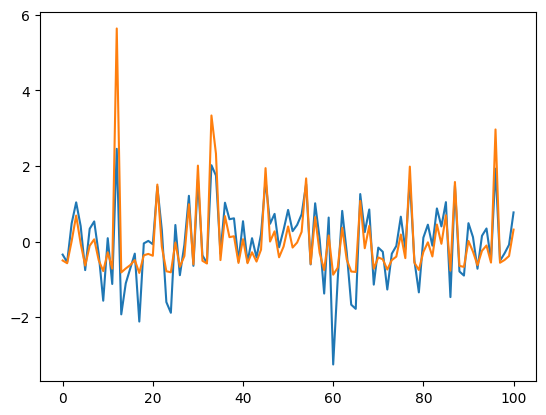

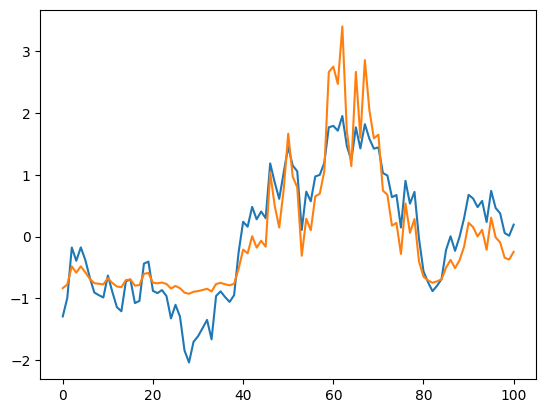

In [25]:
from processes_generators.arx_processes import generate_ARX_multiexog

n_features = 60
alphas = [0.1, 0.9]
sample_len = 101
step_seed = 1029

for alpha in alphas:
    fig = plt.figure()
    # Parameters for the multidimensional distributions
    mean_1 = np.zeros(int(n_features / 3))  # Mean vector for the first distribution
    mean_2 = np.zeros(int(n_features / 3))  # Mean vector for the second distribution
    mean_3 = np.zeros(int(n_features / 3))  # Mean vector for the third distribution

    cov_1 = (
        np.eye(int(n_features / 3)) * 1
    )  # Covariance matrix for the first distribution, 3 is the variance TODO vary the correlation coeffs
    cov_1[cov_1 == 0] = 0.9
    cov_2 = (
        np.eye(int(n_features / 3)) * 1
    )  # Covariance matrix for the second distribution
    cov_2[cov_2 == 0] = 0.9
    cov_3 = (
        np.eye(int(n_features / 3)) * 1
    )  # Covariance matrix for the third distribution
    cov_3[cov_3 == 0] = 0.9

    # Generate multidimensional samples
    X_features = [
        np.random.multivariate_normal(mean_1, cov_1, sample_len).T,
        np.random.multivariate_normal(mean_2, cov_2, sample_len).T,
        np.random.multivariate_normal(mean_3, cov_3, sample_len).T,
    ]

    X_labels = [
        0 * np.ones(int(n_features / 3)),
        np.ones(int(n_features / 3)),
        2 * np.ones(int(n_features / 3)),
    ]

    # Flatten the list to have all features in a single list
    X_features = [x for group in X_features for x in group]
    X_labels = [x for group in X_labels for x in group]
    # Generate ARX series
    rng = np.random.default_rng(seed=step_seed)
    exog_coeff = rng.uniform(-1, 1, n_features)
    Y = generate_ARX_multiexog(
        [alpha], exog_coeff, 1, X_features, sample_len, step_seed
    )

    Y = (Y - np.mean(Y)) / np.std(Y)

    plt.plot(Y)

    Y = np.exp(Y)
    Y = (Y - np.mean(Y)) / np.std(Y)

    plt.plot(Y)

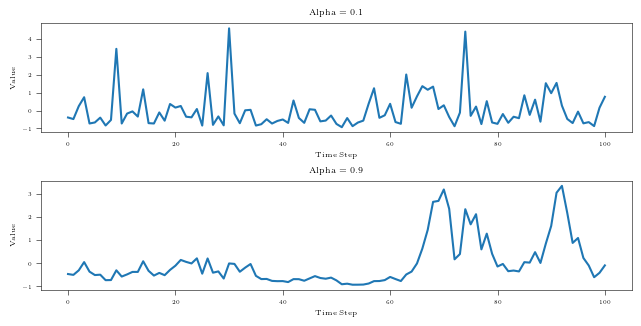

In [41]:
from processes_generators.arx_processes import generate_ARX_multiexog
import matplotlib.pyplot as plt
import numpy as np

n_features = 60
alphas = [0.1, 0.9]
sample_len = 101
step_seed = 300

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(
    2, 1, figsize=(Paper_width, 0.5 * Paper_width), constrained_layout=True
)

for idx, alpha in enumerate(alphas):
    ax = axes[idx]  # Select the corresponding subplot

    # Parameters for the multidimensional distributions
    mean_1 = np.zeros(int(n_features / 3))  # Mean vector for the first distribution
    mean_2 = np.zeros(int(n_features / 3))  # Mean vector for the second distribution
    mean_3 = np.zeros(int(n_features / 3))  # Mean vector for the third distribution

    cov_1 = (
        np.eye(int(n_features / 3)) * 1
    )  # Covariance matrix for the first distribution
    cov_1[cov_1 == 0] = 0.9
    cov_2 = (
        np.eye(int(n_features / 3)) * 1
    )  # Covariance matrix for the second distribution
    cov_2[cov_2 == 0] = 0.9
    cov_3 = (
        np.eye(int(n_features / 3)) * 1
    )  # Covariance matrix for the third distribution
    cov_3[cov_3 == 0] = 0.9

    rng = np.random.default_rng(seed=step_seed)
    part_1 = rng.multivariate_normal(mean_1, cov_1, sample_len).T
    rng = np.random.default_rng(seed=step_seed)
    part_2 = rng.multivariate_normal(mean_2, cov_2, sample_len).T
    rng = np.random.default_rng(seed=step_seed)
    part_3 = rng.multivariate_normal(mean_3, cov_3, sample_len).T
    # Generate multidimensional samples
    X_features = [part_1, part_2, part_3]

    X_labels = [
        0 * np.ones(int(n_features / 3)),
        np.ones(int(n_features / 3)),
        2 * np.ones(int(n_features / 3)),
    ]

    # Flatten the list to have all features in a single list
    X_features = [x for group in X_features for x in group]
    X_labels = [x for group in X_labels for x in group]

    # Generate ARX series
    rng = np.random.default_rng(seed=step_seed)
    exog_coeff = rng.uniform(-1, 1, n_features)
    Y = generate_ARX_multiexog(
        [alpha], exog_coeff, 1, X_features, sample_len, step_seed
    )

    Y = (Y - np.mean(Y)) / np.std(Y)
    Y = np.exp(Y)
    Y = (Y - np.mean(Y)) / np.std(Y)

    ax.plot(Y)

    ax.set_title(f"Alpha = {alpha}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")

# Add a common title for the figure
plt.savefig("ANALYSIS_PLOTS/trajectory_features_sensitivity.pdf", bbox_inches="tight")

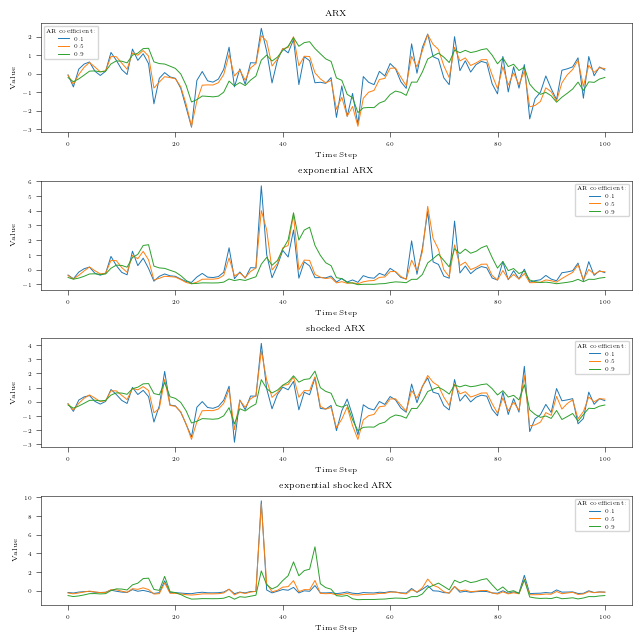

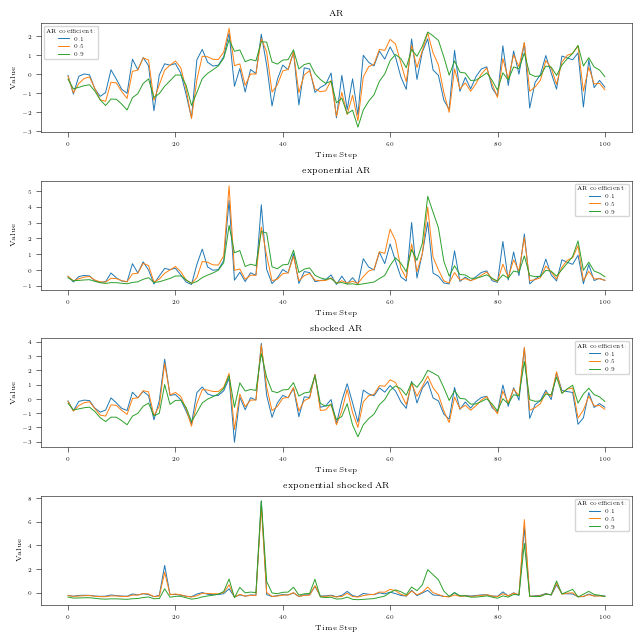

In [42]:
from processes_generators.generate_sample_and_predictors import (
    generate_sample_and_predictors,
)
import matplotlib.pyplot as plt

mc_config = prod_mc_config
seed = 300

title_map = {
    "ARX_noshock": "ARX",
    "ARX_exp_noshock": "exponential ARX",
    "ARX": "shocked ARX",
    "ARX_exp": "exponential shocked ARX",
    "AR_noshock": "AR",
    "AR_exp_noshock": "exponential AR",
    "AR": "shocked AR",
    "AR_exp": "exponential shocked AR",
}

alphas = [0.1, 0.5, 0.9]

for models_group in [
    ["ARX_noshock", "ARX_exp_noshock", "ARX", "ARX_exp"],
    ["AR_noshock", "AR_exp_noshock", "AR", "AR_exp"],
]:
    # Determine the number of models to create subplots
    num_models = len(models_group)

    fig, axes = plt.subplots(
        num_models, 1, figsize=(Paper_width, Paper_width), constrained_layout=True
    )

    for model_index, model in enumerate(models_group):
        ax = axes[model_index] if num_models > 1 else axes  # Handle single subplot case

        for params_index, models_params in enumerate(
            mc_config["model_params_sets"][model]
        ):
            # Assuming models_params contains the AR coefficients
            ar_coeffs = models_params.get(
                "AR_coefficients", [0.0]
            )  # Adjust key if necessary

            X, Y = generate_sample_and_predictors(model, models_params, 101, seed)
            ax.plot(Y, label=f"{alphas[params_index]}", lw=0.7)

        ax.set_title(title_map[model])
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(title="AR coefficient:")

    # Add a common title for the figure
    plt.savefig("ANALYSIS_PLOTS/trajectory_params_sensitivity.pdf", bbox_inches="tight")